# Modelos 

In [21]:
## Imports
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import random
import imblearn
import seaborn as sns
from sklearn.metrics import roc_auc_score,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Loading dataset
## Define your path to the features.csv file

In [18]:
data = pd.read_csv("D:/DATASET LIDC-IDRI/processeddata/features.csv")
data = data.dropna()
data=data.drop(['diagnostics_Mask-original_CenterOfMass','diagnostics_Mask-original_CenterOfMassIndex','diagnostics_Versions_PyRadiomics','diagnostics_Versions_Numpy','diagnostics_Versions_SimpleITK','diagnostics_Versions_PyWavelet','diagnostics_Versions_Python','diagnostics_Configuration_Settings','diagnostics_Configuration_EnabledImageTypes','diagnostics_Image-original_Hash','diagnostics_Image-original_Dimensionality','diagnostics_Image-original_Spacing','diagnostics_Image-original_Size','diagnostics_Image-original_Mean','diagnostics_Image-original_Minimum','diagnostics_Image-original_Maximum','diagnostics_Mask-original_Hash','diagnostics_Mask-original_Spacing','diagnostics_Mask-original_Size','diagnostics_Mask-original_BoundingBox','diagnostics_Mask-original_VolumeNum','Sid','Unnamed: 0'],axis=1)

### Feature studying


In [19]:
data["Malignancy"].value_counts()

3    4262
2    3286
5    2511
4    2228
1    2061
Name: Malignancy, dtype: int64

# Data splitting

### For the data split, we decided to split the date by patients and not by slices, so that one patient (who has several splits) is totally either in the training or in the test

In [7]:
## Splitting patients into groups

all_patients = data['Pid'].unique() #732

# Spliting patients into train, test and val groups
train_patients, temp_patients = train_test_split(all_patients, test_size=0.3, random_state=42)
test_patients, val_patients = train_test_split(temp_patients, test_size=0.5, random_state=42)

# Creating the train, test and val datasets
train_data = data[data['Pid'].isin(train_patients)]
test_data = data[data['Pid'].isin(test_patients)]
val_data = data[data['Pid'].isin(val_patients)]

# Our goal is to test the model on unseen data, and identify whether the patient has cancer or not ( 1 or 0 )

## As the malignancy value ranges from 0 to 5, we decided to map the values 1 and 2 to 0 and 4 and 5 to 1
## In relation to 3, we took a few different approaches to see which best suited the problem...



# 1st Approach -> Map malignancy 3 to 0

In [8]:
X_train = train_data.drop(['Pid','Malignancy'], axis=1)
X_test = test_data.drop(['Pid','Malignancy'], axis=1)
X_val = val_data.drop(['Pid','Malignancy'], axis=1)
y_train = train_data['Malignancy']
y_test = test_data['Malignancy']
y_val = val_data['Malignancy']

# Mapping malignancy levels to binary labels
y_train = y_train.map({1: 0, 2: 0,3:0, 4: 1, 5: 1})
y_val = y_val.map({1: 0, 2: 0,3:0, 4: 1, 5: 1})
y_test = y_test.map({1: 0, 2: 0,3:0, 4: 1, 5: 1})

# Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

## We decided to do the normalization using Standard Scaling in order to promote the smooth running of the program

### For the neural network, we used a simple one with 1 hidden layer.
### We used the Adam optimizer because it is consistent and popular.
#### We are testing for 20 seasons to see which approach is best.

In [9]:
# Creating neural network, 64 - 32 - 1 com dropout
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, verbose = 2, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# Evaluate your model on the original test data (unbalanced)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

Epoch 1/20
158/158 - 1s - loss: 0.6825 - accuracy: 0.6501 - val_loss: 0.5943 - val_accuracy: 0.6814 - 1s/epoch - 7ms/step
Epoch 2/20
158/158 - 0s - loss: 0.6208 - accuracy: 0.6794 - val_loss: 0.5940 - val_accuracy: 0.6779 - 288ms/epoch - 2ms/step
Epoch 3/20
158/158 - 1s - loss: 0.6142 - accuracy: 0.6832 - val_loss: 0.5990 - val_accuracy: 0.6814 - 516ms/epoch - 3ms/step
Epoch 4/20
158/158 - 0s - loss: 0.6059 - accuracy: 0.6861 - val_loss: 0.5954 - val_accuracy: 0.6801 - 456ms/epoch - 3ms/step
Epoch 5/20
158/158 - 0s - loss: 0.6060 - accuracy: 0.6871 - val_loss: 0.5976 - val_accuracy: 0.6770 - 316ms/epoch - 2ms/step
Epoch 6/20
158/158 - 0s - loss: 0.6009 - accuracy: 0.6956 - val_loss: 0.5979 - val_accuracy: 0.6708 - 293ms/epoch - 2ms/step
Epoch 7/20
158/158 - 0s - loss: 0.5976 - accuracy: 0.6913 - val_loss: 0.5937 - val_accuracy: 0.6787 - 303ms/epoch - 2ms/step
Epoch 8/20
158/158 - 0s - loss: 0.5988 - accuracy: 0.6914 - val_loss: 0.5917 - val_accuracy: 0.6748 - 292ms/epoch - 2ms/step
Epo

# 2nd Approach -> Map malignancy 3 to 1

In [11]:
y2_train = train_data['Malignancy']
y2_test = test_data['Malignancy']
y2_val = val_data['Malignancy']
# Mapping malignancy levels to binary labels
y2_train = y2_train.map({1: 0, 2: 0,3:1, 4: 1, 5: 1})
y2_val = y2_val.map({1: 0, 2: 0,3:1, 4: 1, 5: 1})
y2_test = y2_test.map({1: 0, 2: 0,3:1, 4: 1, 5: 1})


In [12]:
history = model.fit(X_train, y2_train, verbose = 2, epochs=20, batch_size=64, validation_data=(X_val, y2_val))

# Evaluate your model on the original test data (unbalanced)
test_loss, test_accuracy = model.evaluate(X_test, y2_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

Epoch 1/20
158/158 - 0s - loss: 0.6809 - accuracy: 0.5619 - val_loss: 0.6510 - val_accuracy: 0.5904 - 362ms/epoch - 2ms/step
Epoch 2/20
158/158 - 0s - loss: 0.6461 - accuracy: 0.6159 - val_loss: 0.6467 - val_accuracy: 0.6098 - 310ms/epoch - 2ms/step
Epoch 3/20
158/158 - 0s - loss: 0.6427 - accuracy: 0.6263 - val_loss: 0.6461 - val_accuracy: 0.6226 - 304ms/epoch - 2ms/step
Epoch 4/20
158/158 - 0s - loss: 0.6378 - accuracy: 0.6305 - val_loss: 0.6393 - val_accuracy: 0.6209 - 296ms/epoch - 2ms/step
Epoch 5/20
158/158 - 0s - loss: 0.6375 - accuracy: 0.6336 - val_loss: 0.6543 - val_accuracy: 0.6186 - 304ms/epoch - 2ms/step
Epoch 6/20
158/158 - 0s - loss: 0.6361 - accuracy: 0.6381 - val_loss: 0.6405 - val_accuracy: 0.6368 - 282ms/epoch - 2ms/step
Epoch 7/20
158/158 - 0s - loss: 0.6355 - accuracy: 0.6367 - val_loss: 0.6384 - val_accuracy: 0.6341 - 281ms/epoch - 2ms/step
Epoch 8/20
158/158 - 0s - loss: 0.6357 - accuracy: 0.6418 - val_loss: 0.6431 - val_accuracy: 0.6376 - 289ms/epoch - 2ms/step


# 3rd Approach -> Eliminate all data with malignancy = 3

In [16]:
## Erasing entries with mal==3
i = data[data['Malignancy'] == 3].index
data3 = data.drop(i)


## Splitting patients into groups

all_patients = data3['Pid'].unique() 

# Spliting patients into train, test and val groups
train_patients, temp_patients = train_test_split(all_patients, test_size=0.3, random_state=42)
test_patients, val_patients = train_test_split(temp_patients, test_size=0.5, random_state=42)

# Creating the train, test and val datasets
train_data3 = data3[data3['Pid'].isin(train_patients)]
test_data3 = data3[data3['Pid'].isin(test_patients)]
val_data3 = data3[data3['Pid'].isin(val_patients)]


X_train = train_data3.drop(['Pid','Malignancy'], axis=1)
X_test = test_data3.drop(['Pid','Malignancy'], axis=1)
X_val = val_data3.drop(['Pid','Malignancy'], axis=1)
y_train = train_data3['Malignancy']
y_test = test_data3['Malignancy']
y_val = val_data3['Malignancy']

# Mapping malignancy levels to binary labels
y_train = y_train.map({1: 0, 2: 0, 4: 1, 5: 1})
y_val = y_val.map({1: 0, 2: 0, 4: 1, 5: 1})
y_test = y_test.map({1: 0, 2: 0,4: 1, 5: 1})

# Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


# Creating neural network, 64 - 32 - 1 com dropout
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, verbose = 2, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# Evaluate your model on the original test data (unbalanced)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')


Epoch 1/20
109/109 - 1s - loss: 0.7377 - accuracy: 0.5775 - val_loss: 0.6360 - val_accuracy: 0.6692 - 1s/epoch - 11ms/step
Epoch 2/20
109/109 - 0s - loss: 0.6720 - accuracy: 0.6128 - val_loss: 0.6251 - val_accuracy: 0.7012 - 226ms/epoch - 2ms/step
Epoch 3/20
109/109 - 0s - loss: 0.6596 - accuracy: 0.6319 - val_loss: 0.6182 - val_accuracy: 0.7005 - 359ms/epoch - 3ms/step
Epoch 4/20
109/109 - 0s - loss: 0.6516 - accuracy: 0.6381 - val_loss: 0.6236 - val_accuracy: 0.7052 - 364ms/epoch - 3ms/step
Epoch 5/20
109/109 - 0s - loss: 0.6544 - accuracy: 0.6339 - val_loss: 0.6227 - val_accuracy: 0.6998 - 237ms/epoch - 2ms/step
Epoch 6/20
109/109 - 0s - loss: 0.6493 - accuracy: 0.6391 - val_loss: 0.6269 - val_accuracy: 0.7012 - 270ms/epoch - 2ms/step
Epoch 7/20
109/109 - 0s - loss: 0.6441 - accuracy: 0.6526 - val_loss: 0.6236 - val_accuracy: 0.7012 - 286ms/epoch - 3ms/step
Epoch 8/20
109/109 - 0s - loss: 0.6438 - accuracy: 0.6484 - val_loss: 0.6237 - val_accuracy: 0.7059 - 284ms/epoch - 3ms/step
Ep

# 4th Approach -> Turn all 3 into 0 and 1 at the same time

### Instead of deleting the entries of mal=3 or mapping them all to 0 or 1, we had the idea to map the high 3's to 1 and the low 3's to 0. We did that by mapping the data into {1: 0, 2: 0, 4: 1, 5: 1} and sperating the data into the ones labeled as 0 and 1, and the ones labeled as 3. We trained the model on the binary dataset and predicted the dataset with our 3's. 

In [28]:
## Separating the data onto 01 and 3

df = data
df['malignancy_mapped'] = df['Malignancy'].map({1: 0, 2: 0, 4: 1, 5: 1})
df01 = df[df['malignancy_mapped'].isin([0, 1])]
df3 = df[df['Malignancy'] == 3]


# Separate the features and labels for the 0-1 labeled instances
features_01 = df01.drop(['Malignancy', 'malignancy_mapped', 'Pid'], axis=1)
labels_01 = df01['malignancy_mapped']

# Separate the features for label 3 instances
features_3 = df3.drop(['Malignancy', 'malignancy_mapped', 'Pid'], axis=1)

# Train a model on 0-1 labeled instances
X_train, X_test, y_train, y_test = train_test_split(features_01, labels_01, test_size=0.2, random_state=50)
model = LogisticRegression(max_iter=1000) 
model.fit(X_train, y_train)

# Predict probabilities for label 3 instances
probs = model.predict_proba(features_3)

# Threshold to determine the 3+s and the 3-s
threshold = 0.4885    
labels_3_mapped = np.where(probs[:, 1] >= threshold, 1, 0)
mapped_labels_3 = pd.Series(labels_3_mapped, index=df3.index)

# Combine all the labels
final_labels = pd.concat([labels_01, mapped_labels_3], axis=0).sort_index()

# Updating the dataset
df = df.drop(['malignancy_mapped','Malignancy'],axis=1)
df['Malv2'] = final_labels

## We fine-tuned the threshold to have the same number of 0's and 1's, to prevent class inbalance

In [29]:
df["Malv2"].value_counts()

0.0    7186
1.0    7162
Name: Malv2, dtype: int64

In [31]:
all_patients = df['Pid'].unique() 

# Spliting patients into train, test and val groups
train_patients, temp_patients = train_test_split(all_patients, test_size=0.3, random_state=42)
test_patients, val_patients = train_test_split(temp_patients, test_size=0.5, random_state=42)

# Creating the train, test and val datasets
train_data4 = df[df['Pid'].isin(train_patients)]
test_data4 = df[df['Pid'].isin(test_patients)]
val_data4 = df[df['Pid'].isin(val_patients)]


X_train = train_data4.drop(['Pid','Malv2'], axis=1)
X_test = test_data4.drop(['Pid','Malv2'], axis=1)
X_val = val_data4.drop(['Pid','Malv2'], axis=1)
y_train = train_data4['Malv2']
y_test = test_data4['Malv2']
y_val = val_data4['Malv2']

# Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


# Creating neural network, 64 - 32 - 1 com dropout
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, verbose = 2, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# Evaluate your model on the original test data (unbalanced)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

Epoch 1/20
158/158 - 1s - loss: 0.7148 - accuracy: 0.6026 - val_loss: 0.6195 - val_accuracy: 0.6867 - 952ms/epoch - 6ms/step
Epoch 2/20
158/158 - 0s - loss: 0.6439 - accuracy: 0.6511 - val_loss: 0.6046 - val_accuracy: 0.6982 - 299ms/epoch - 2ms/step
Epoch 3/20
158/158 - 0s - loss: 0.6286 - accuracy: 0.6746 - val_loss: 0.6065 - val_accuracy: 0.6955 - 287ms/epoch - 2ms/step
Epoch 4/20
158/158 - 0s - loss: 0.6207 - accuracy: 0.6744 - val_loss: 0.6016 - val_accuracy: 0.7035 - 284ms/epoch - 2ms/step
Epoch 5/20
158/158 - 0s - loss: 0.6141 - accuracy: 0.6836 - val_loss: 0.5939 - val_accuracy: 0.7101 - 282ms/epoch - 2ms/step
Epoch 6/20
158/158 - 0s - loss: 0.6141 - accuracy: 0.6841 - val_loss: 0.5929 - val_accuracy: 0.7017 - 283ms/epoch - 2ms/step
Epoch 7/20
158/158 - 0s - loss: 0.6115 - accuracy: 0.6867 - val_loss: 0.5989 - val_accuracy: 0.7008 - 292ms/epoch - 2ms/step
Epoch 8/20
158/158 - 0s - loss: 0.6107 - accuracy: 0.6860 - val_loss: 0.5953 - val_accuracy: 0.6947 - 287ms/epoch - 2ms/step


## Results :
### 1st Approach -> 0.69 accuracy
### 2nd Approach -> 0.62 accuracy
### 3rd Approach -> 0.64 accuracy
### 4th Approach -> 0.71 accuracy

## Let's proceed with the NN hyperparameter tests and adjustments with the 4th approach

# 1 -> Trying out different NN

## 16 - 16 - 1 without dropout

In [42]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(16, activation=tf.nn.relu),
keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, verbose = 2, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# Evaluate your model on the original test data (unbalanced)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

Epoch 1/20
158/158 - 1s - loss: 0.6232 - accuracy: 0.6713 - val_loss: 0.6055 - val_accuracy: 0.6876 - 998ms/epoch - 6ms/step
Epoch 2/20
158/158 - 0s - loss: 0.5946 - accuracy: 0.6926 - val_loss: 0.6004 - val_accuracy: 0.6876 - 357ms/epoch - 2ms/step
Epoch 3/20
158/158 - 0s - loss: 0.5896 - accuracy: 0.6938 - val_loss: 0.6027 - val_accuracy: 0.6832 - 257ms/epoch - 2ms/step
Epoch 4/20
158/158 - 0s - loss: 0.5870 - accuracy: 0.6957 - val_loss: 0.5925 - val_accuracy: 0.7039 - 249ms/epoch - 2ms/step
Epoch 5/20
158/158 - 0s - loss: 0.5844 - accuracy: 0.6993 - val_loss: 0.5987 - val_accuracy: 0.6920 - 318ms/epoch - 2ms/step
Epoch 6/20
158/158 - 0s - loss: 0.5822 - accuracy: 0.6997 - val_loss: 0.5979 - val_accuracy: 0.6863 - 324ms/epoch - 2ms/step
Epoch 7/20
158/158 - 0s - loss: 0.5807 - accuracy: 0.7042 - val_loss: 0.5949 - val_accuracy: 0.6973 - 347ms/epoch - 2ms/step
Epoch 8/20
158/158 - 0s - loss: 0.5797 - accuracy: 0.7027 - val_loss: 0.5953 - val_accuracy: 0.6986 - 371ms/epoch - 2ms/step


## 87 - 128 - 64 - 1

In [53]:
print(len(df.columns))   #vamos meter 89 neurónios na input layer

89


In [54]:
model = keras.Sequential([
    layers.Input(shape=(89-2,)),  # Input layer with 80 features
    layers.Dense(128, activation='relu'),  # Hidden layer with 128 units and ReLU activation
    layers.Dropout(0.3),  # Dropout layer to prevent overfitting
    layers.Dense(64, activation='relu'),  # Hidden layer with 64 units and ReLU activation
    layers.Dropout(0.3),  # Dropout layer to prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation for binary classification
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, verbose = 2, epochs=20, batch_size=64, validation_data=(X_val, y_val))

# Evaluate your model on the original test data (unbalanced)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')



Epoch 1/20
158/158 - 1s - loss: 0.6322 - accuracy: 0.6680 - val_loss: 0.6022 - val_accuracy: 0.6902 - 951ms/epoch - 6ms/step
Epoch 2/20
158/158 - 0s - loss: 0.6087 - accuracy: 0.6825 - val_loss: 0.5939 - val_accuracy: 0.6964 - 315ms/epoch - 2ms/step
Epoch 3/20
158/158 - 0s - loss: 0.5997 - accuracy: 0.6910 - val_loss: 0.5995 - val_accuracy: 0.6911 - 309ms/epoch - 2ms/step
Epoch 4/20
158/158 - 0s - loss: 0.5974 - accuracy: 0.6927 - val_loss: 0.5917 - val_accuracy: 0.7022 - 312ms/epoch - 2ms/step
Epoch 5/20
158/158 - 0s - loss: 0.5969 - accuracy: 0.6968 - val_loss: 0.5960 - val_accuracy: 0.6933 - 312ms/epoch - 2ms/step
Epoch 6/20
158/158 - 0s - loss: 0.5913 - accuracy: 0.6968 - val_loss: 0.5954 - val_accuracy: 0.7026 - 312ms/epoch - 2ms/step
Epoch 7/20
158/158 - 0s - loss: 0.5920 - accuracy: 0.6978 - val_loss: 0.5962 - val_accuracy: 0.6973 - 318ms/epoch - 2ms/step
Epoch 8/20
158/158 - 0s - loss: 0.5881 - accuracy: 0.6985 - val_loss: 0.5997 - val_accuracy: 0.6898 - 320ms/epoch - 2ms/step


# We realized that the accuracy doesn't change, so we'll continue with the original neural network from the first tests

# 2-> Checking the best epoch number ( early stopping )

Epoch 1/300
158/158 - 1s - loss: 0.6957 - accuracy: 0.6118 - val_loss: 0.6108 - val_accuracy: 0.6858 - 957ms/epoch - 6ms/step
Epoch 2/300
158/158 - 0s - loss: 0.6462 - accuracy: 0.6566 - val_loss: 0.6044 - val_accuracy: 0.7000 - 292ms/epoch - 2ms/step
Epoch 3/300
158/158 - 0s - loss: 0.6322 - accuracy: 0.6671 - val_loss: 0.6013 - val_accuracy: 0.6982 - 329ms/epoch - 2ms/step
Epoch 4/300
158/158 - 0s - loss: 0.6219 - accuracy: 0.6763 - val_loss: 0.5975 - val_accuracy: 0.7039 - 359ms/epoch - 2ms/step
Epoch 5/300
158/158 - 0s - loss: 0.6154 - accuracy: 0.6803 - val_loss: 0.5983 - val_accuracy: 0.6977 - 393ms/epoch - 2ms/step
Epoch 6/300
158/158 - 0s - loss: 0.6141 - accuracy: 0.6815 - val_loss: 0.5975 - val_accuracy: 0.7030 - 488ms/epoch - 3ms/step
Epoch 7/300
158/158 - 0s - loss: 0.6129 - accuracy: 0.6871 - val_loss: 0.6038 - val_accuracy: 0.7022 - 434ms/epoch - 3ms/step
Epoch 8/300
158/158 - 0s - loss: 0.6079 - accuracy: 0.6890 - val_loss: 0.6016 - val_accuracy: 0.7000 - 409ms/epoch - 3

Epoch 66/300
158/158 - 1s - loss: 0.5842 - accuracy: 0.7014 - val_loss: 0.5903 - val_accuracy: 0.7057 - 654ms/epoch - 4ms/step
Epoch 67/300
158/158 - 0s - loss: 0.5840 - accuracy: 0.7020 - val_loss: 0.5882 - val_accuracy: 0.7039 - 483ms/epoch - 3ms/step
Epoch 68/300
158/158 - 0s - loss: 0.5836 - accuracy: 0.6995 - val_loss: 0.5895 - val_accuracy: 0.7013 - 486ms/epoch - 3ms/step
Epoch 69/300
158/158 - 0s - loss: 0.5845 - accuracy: 0.6977 - val_loss: 0.5893 - val_accuracy: 0.7008 - 407ms/epoch - 3ms/step
Epoch 70/300
158/158 - 0s - loss: 0.5815 - accuracy: 0.7008 - val_loss: 0.5893 - val_accuracy: 0.7066 - 402ms/epoch - 3ms/step
Epoch 71/300
158/158 - 0s - loss: 0.5841 - accuracy: 0.7013 - val_loss: 0.5914 - val_accuracy: 0.6995 - 346ms/epoch - 2ms/step
Epoch 72/300
158/158 - 0s - loss: 0.5827 - accuracy: 0.7047 - val_loss: 0.5865 - val_accuracy: 0.7048 - 380ms/epoch - 2ms/step
Epoch 73/300
158/158 - 0s - loss: 0.5860 - accuracy: 0.7047 - val_loss: 0.5901 - val_accuracy: 0.6986 - 407ms/e

Epoch 131/300
158/158 - 1s - loss: 0.5713 - accuracy: 0.7048 - val_loss: 0.5928 - val_accuracy: 0.7048 - 683ms/epoch - 4ms/step
Epoch 132/300
158/158 - 0s - loss: 0.5711 - accuracy: 0.7087 - val_loss: 0.5919 - val_accuracy: 0.7044 - 472ms/epoch - 3ms/step
Epoch 133/300
158/158 - 0s - loss: 0.5744 - accuracy: 0.7072 - val_loss: 0.5913 - val_accuracy: 0.6973 - 383ms/epoch - 2ms/step
Epoch 134/300
158/158 - 0s - loss: 0.5732 - accuracy: 0.7033 - val_loss: 0.5918 - val_accuracy: 0.7017 - 345ms/epoch - 2ms/step
Epoch 135/300
158/158 - 0s - loss: 0.5724 - accuracy: 0.7093 - val_loss: 0.5933 - val_accuracy: 0.6955 - 364ms/epoch - 2ms/step
Epoch 136/300
158/158 - 0s - loss: 0.5721 - accuracy: 0.7041 - val_loss: 0.5981 - val_accuracy: 0.7008 - 373ms/epoch - 2ms/step
Epoch 137/300
158/158 - 0s - loss: 0.5723 - accuracy: 0.7055 - val_loss: 0.5985 - val_accuracy: 0.7066 - 354ms/epoch - 2ms/step
Epoch 138/300
158/158 - 0s - loss: 0.5721 - accuracy: 0.7080 - val_loss: 0.5999 - val_accuracy: 0.6951 -

158/158 - 0s - loss: 0.5658 - accuracy: 0.7097 - val_loss: 0.5975 - val_accuracy: 0.7017 - 353ms/epoch - 2ms/step
Epoch 196/300
158/158 - 0s - loss: 0.5685 - accuracy: 0.7068 - val_loss: 0.5974 - val_accuracy: 0.7022 - 335ms/epoch - 2ms/step
Epoch 197/300
158/158 - 0s - loss: 0.5621 - accuracy: 0.7070 - val_loss: 0.5997 - val_accuracy: 0.7004 - 359ms/epoch - 2ms/step
Epoch 198/300
158/158 - 0s - loss: 0.5611 - accuracy: 0.7101 - val_loss: 0.6000 - val_accuracy: 0.7004 - 337ms/epoch - 2ms/step
Epoch 199/300
158/158 - 0s - loss: 0.5656 - accuracy: 0.7085 - val_loss: 0.5926 - val_accuracy: 0.6986 - 325ms/epoch - 2ms/step
Epoch 200/300
158/158 - 0s - loss: 0.5667 - accuracy: 0.7058 - val_loss: 0.5968 - val_accuracy: 0.7057 - 320ms/epoch - 2ms/step
Epoch 201/300
158/158 - 0s - loss: 0.5665 - accuracy: 0.7064 - val_loss: 0.5964 - val_accuracy: 0.7026 - 336ms/epoch - 2ms/step
Epoch 202/300
158/158 - 0s - loss: 0.5623 - accuracy: 0.7106 - val_loss: 0.5992 - val_accuracy: 0.6942 - 362ms/epoch -

Epoch 260/300
158/158 - 0s - loss: 0.5612 - accuracy: 0.7091 - val_loss: 0.6031 - val_accuracy: 0.6986 - 325ms/epoch - 2ms/step
Epoch 261/300
158/158 - 0s - loss: 0.5611 - accuracy: 0.7116 - val_loss: 0.6001 - val_accuracy: 0.6951 - 341ms/epoch - 2ms/step
Epoch 262/300
158/158 - 0s - loss: 0.5602 - accuracy: 0.7100 - val_loss: 0.6027 - val_accuracy: 0.6907 - 316ms/epoch - 2ms/step
Epoch 263/300
158/158 - 0s - loss: 0.5611 - accuracy: 0.7082 - val_loss: 0.6001 - val_accuracy: 0.6818 - 337ms/epoch - 2ms/step
Epoch 264/300
158/158 - 0s - loss: 0.5611 - accuracy: 0.7094 - val_loss: 0.6059 - val_accuracy: 0.6955 - 327ms/epoch - 2ms/step
Epoch 265/300
158/158 - 0s - loss: 0.5607 - accuracy: 0.7098 - val_loss: 0.5995 - val_accuracy: 0.6765 - 337ms/epoch - 2ms/step
Epoch 266/300
158/158 - 0s - loss: 0.5593 - accuracy: 0.7102 - val_loss: 0.6067 - val_accuracy: 0.7039 - 334ms/epoch - 2ms/step
Epoch 267/300
158/158 - 1s - loss: 0.5617 - accuracy: 0.7080 - val_loss: 0.6047 - val_accuracy: 0.6814 -

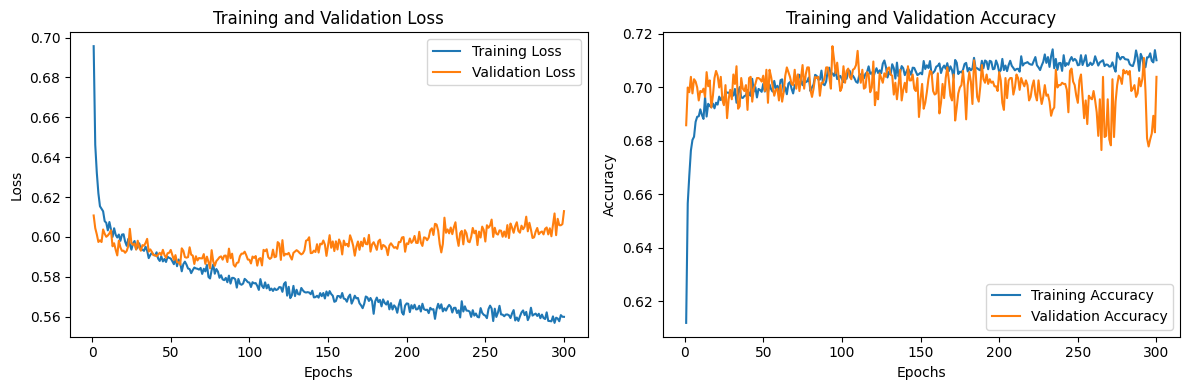

In [58]:
# Creating neural network, 64 - 32 - 1 com dropout
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, verbose = 2, epochs=300, batch_size=64, validation_data=(X_val, y_val))

# Evaluate your model on the original test data (unbalanced)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')


# Get the training and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Get the training and validation accuracy from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']



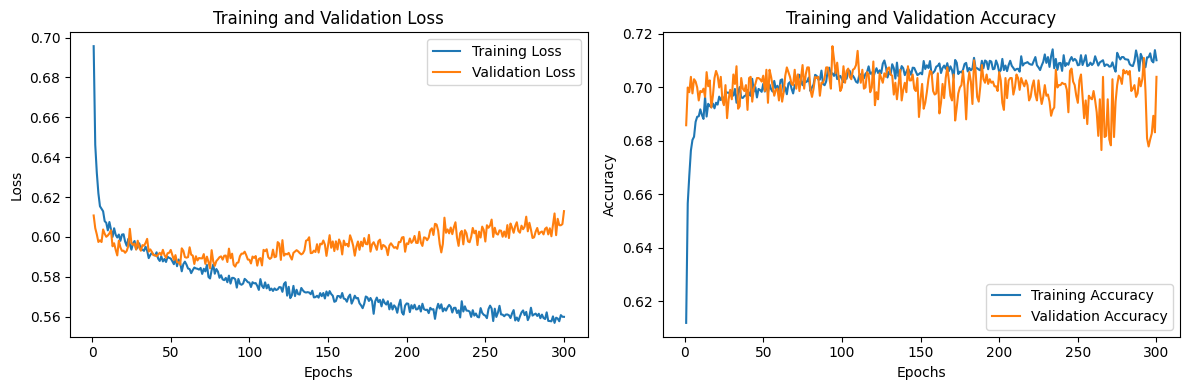

In [59]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


# Conclusions : From 75 epochs ( +/-) the validation loss started to rise due to overfitting.

# 3 -> Checking the best batch size hyperparameter

In [37]:
max_acc = 0
i = 4
best_batch = 0
while (i < 129): # testar 4,8,16,32,64,128
    

    history = model.fit(X_train, y_train, epochs=20,verbose = 0, batch_size=i, validation_data=(X_val, y_val))
# Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    if (test_accuracy > max_acc) :
        max_acc = test_accuracy
        best_batch = i
    print("Batch size = ",i)
    print(f'Test Accuracy: {test_accuracy:.2f}')
    i = i*2
print("The best Batch size is ",best_batch)

64/64 [==============================] - 0s 2ms/step - loss: 0.6293 - accuracy: 0.6933
Batch size =  4
Test Accuracy: 0.69
64/64 [==============================] - 0s 2ms/step - loss: 0.6376 - accuracy: 0.6859
Batch size =  8
Test Accuracy: 0.69
64/64 [==============================] - 0s 2ms/step - loss: 0.6293 - accuracy: 0.6879
Batch size =  16
Test Accuracy: 0.69
64/64 [==============================] - 0s 2ms/step - loss: 0.6589 - accuracy: 0.6874
Batch size =  32
Test Accuracy: 0.69
64/64 [==============================] - 0s 2ms/step - loss: 0.6542 - accuracy: 0.6869
Batch size =  64
Test Accuracy: 0.69
64/64 [==============================] - 0s 2ms/step - loss: 0.6490 - accuracy: 0.6898
Batch size =  128
Test Accuracy: 0.69
The best Batch size is  4


## Results :
### We noticed that the loss increased as the batch_size increased, but the accuracy did not change significantly

64/64 [==============================] - 0s 2ms/step
Confusion Matrix:


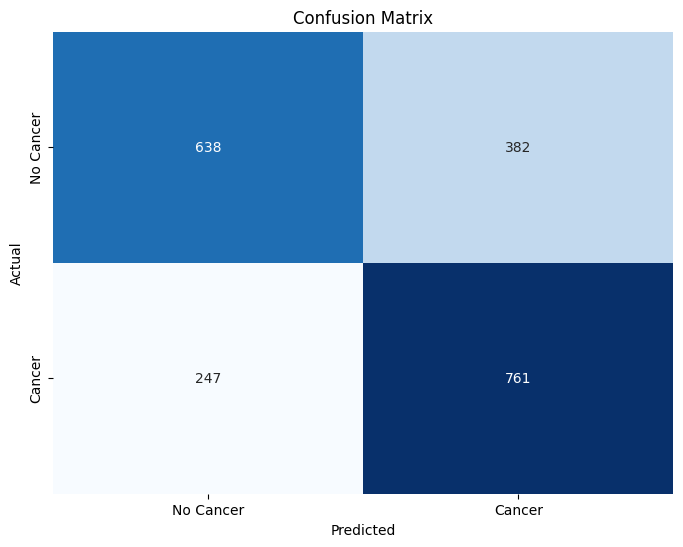

Accuracy: 0.69
Precision: 0.67
Recall: 0.75
F1-score: 0.71
Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.63      0.67      1020
         1.0       0.67      0.75      0.71      1008

    accuracy                           0.69      2028
   macro avg       0.69      0.69      0.69      2028
weighted avg       0.69      0.69      0.69      2028



In [64]:
#let me see the confusion matrix
y_prob = model.predict(X_test)
#print(y_prob)
threshold = 0.5
y_pred = (y_prob > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
#print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# You can also calculate other metrics like accuracy, precision, recall, etc.
# For example, accuracy:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1:.2f}")

# Generate a classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)


## Accuracy: 0.69
## Precision: 0.67
## Recall: 0.75
## F1-score: 0.71

In [99]:
# Number of false positives and false negatives
false_positives = 382
false_negatives = 247

# Total number of negatives and positives
total_negatives = 1020
total_positives = 1008

# Calculate error rates
error_type_1 = (false_positives / total_negatives) * 100
error_type_2 = (false_negatives / total_positives) * 100

# Print the error rates
print(f"Error Type 1 (False Positive) Rate: {error_type_1:.2f}%")
print(f"Error Type 2 (False Negative) Rate: {error_type_2:.2f}%")


Error Type 1 (False Positive) Rate: 37.45%
Error Type 2 (False Negative) Rate: 24.50%


# Final NN

In [94]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, verbose = 2, epochs=75, batch_size=4, validation_data=(X_val, y_val))

# Evaluate your model on the original test data (unbalanced)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')


Epoch 1/75
2515/2515 - 6s - loss: 0.6735 - accuracy: 0.6416 - val_loss: 0.6161 - val_accuracy: 0.6810 - 6s/epoch - 2ms/step
Epoch 2/75
2515/2515 - 4s - loss: 0.6296 - accuracy: 0.6676 - val_loss: 0.6074 - val_accuracy: 0.6924 - 4s/epoch - 2ms/step
Epoch 3/75
2515/2515 - 4s - loss: 0.6197 - accuracy: 0.6823 - val_loss: 0.5905 - val_accuracy: 0.7013 - 4s/epoch - 1ms/step
Epoch 4/75
2515/2515 - 4s - loss: 0.6182 - accuracy: 0.6854 - val_loss: 0.6030 - val_accuracy: 0.6929 - 4s/epoch - 2ms/step
Epoch 5/75
2515/2515 - 7s - loss: 0.6133 - accuracy: 0.6855 - val_loss: 0.5973 - val_accuracy: 0.7004 - 7s/epoch - 3ms/step
Epoch 6/75
2515/2515 - 4s - loss: 0.6114 - accuracy: 0.6872 - val_loss: 0.5979 - val_accuracy: 0.7044 - 4s/epoch - 2ms/step
Epoch 7/75
2515/2515 - 4s - loss: 0.6128 - accuracy: 0.6903 - val_loss: 0.5958 - val_accuracy: 0.7053 - 4s/epoch - 2ms/step
Epoch 8/75
2515/2515 - 5s - loss: 0.6125 - accuracy: 0.6935 - val_loss: 0.5929 - val_accuracy: 0.7066 - 5s/epoch - 2ms/step
Epoch 9/

Epoch 67/75
2515/2515 - 4s - loss: 0.5913 - accuracy: 0.7035 - val_loss: 0.6011 - val_accuracy: 0.7048 - 4s/epoch - 1ms/step
Epoch 68/75
2515/2515 - 5s - loss: 0.5867 - accuracy: 0.7028 - val_loss: 0.5953 - val_accuracy: 0.7119 - 5s/epoch - 2ms/step
Epoch 69/75
2515/2515 - 4s - loss: 0.5908 - accuracy: 0.6976 - val_loss: 0.5970 - val_accuracy: 0.7044 - 4s/epoch - 1ms/step
Epoch 70/75
2515/2515 - 4s - loss: 0.5865 - accuracy: 0.7006 - val_loss: 0.5991 - val_accuracy: 0.7053 - 4s/epoch - 1ms/step
Epoch 71/75
2515/2515 - 4s - loss: 0.5898 - accuracy: 0.7002 - val_loss: 0.5996 - val_accuracy: 0.6995 - 4s/epoch - 2ms/step
Epoch 72/75
2515/2515 - 4s - loss: 0.5898 - accuracy: 0.7009 - val_loss: 0.5966 - val_accuracy: 0.7030 - 4s/epoch - 2ms/step
Epoch 73/75
2515/2515 - 4s - loss: 0.5873 - accuracy: 0.6979 - val_loss: 0.5951 - val_accuracy: 0.7013 - 4s/epoch - 1ms/step
Epoch 74/75
2515/2515 - 4s - loss: 0.5916 - accuracy: 0.6996 - val_loss: 0.5934 - val_accuracy: 0.7114 - 4s/epoch - 2ms/step


# Trying Support vector machines

In [56]:
## SVM approach (AdaBoost)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif

# Assuming X_train_selected, X_test_selected, y_train, y_test are your selected features and labels

# Initialize an SVM classifier (as the base estimator)
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Initialize AdaBoost classifier using the SVM as the base estimator
adaboost_clf = AdaBoostClassifier(base_estimator=svm_classifier, n_estimators=50, algorithm='SAMME', random_state=42)

# Fit the AdaBoost classifier on the training data
adaboost_clf.fit(X_train, y_train)

# Evaluate on test data
accuracy = adaboost_clf.score(X_test, y_test)
print(f"Accuracy of AdaBoost with SVM base estimator on test set: {accuracy}")

# Evaluate on validation data
accuracy_val = adaboost_clf.score(X_val, y_val)
print(f"Accuracy of AdaBoost with SVM base estimator on validation set: {accuracy_val}")

/Users/rafaelconceicao/opt/anaconda3/envs/LABIACD/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy of AdaBoost with SVM base estimator on test set: 0.6932938856015779
Accuracy of AdaBoost with SVM base estimator on validation set: 0.6924436588599204


## Random forest

In [98]:
## Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=150, random_state=42)

# Train the Random Forest model on the training set
random_forest.fit(X_train, y_train)

# Make predictions on the validation set
predictions_val = random_forest.predict(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, predictions_val)
print("Accuracy of Random Forest on the validation set: {:.2f}%".format(accuracy_val * 100))

# Now, assuming you've finalized your model based on the validation set performance, you can evaluate it on the test set.
predictions_test = random_forest.predict(X_test)
accuracy_test = accuracy_score(y_test, predictions_test)
print("Accuracy of Random Forest on the test set: {:.2f}%".format(accuracy_test * 100))

Accuracy of Random Forest on the validation set: 68.49%
Accuracy of Random Forest on the test set: 67.75%


# Conclusion:
## In the neural network, support vector machine and random forest, the accuracies were similar (67% - 70%)
## The fluctuations in the accuracies in the NN are due to the random initialization of the neural network weights and the stochasticity of the optimization algorithms during training, resulting in small variations in the results with each run